# MS026 Preprocess
01/29/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS026'
subj_format = ['nlx']
subj_site = ['MSSM']


# Make mne_data


In [6]:
load_path = f'{neural_dir}{subj_id}/raw_nlx/'
seeg_names = None
resp_names = None
ekg_names = None
eeg_names = None

In [7]:
### removing extraneous numbering from channel names 

# per Shawn, MSSM data seems to sometime have a "_0000.ncs" to "_9999.ncs" appended to the end of real data
pattern = re.compile(r"_\d{4}\.ncs")  # regex pattern to match "_0000.ncs" to "_9999.ncs"
ncs_files = [x for x in glob(f'{load_path}/*.ncs') if re.search(pattern, x)]
# just in case this changes in the future: 
if len(ncs_files) == 0: 
    ncs_files = glob(f'{load_path}/*.ncs')
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','') for x in glob(f'{load_path}/[R,L]*.ncs')]
else:
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','').split('_')[0] for x in glob(f'{load_path}/[R,L]*.ncs') if re.search(pattern, x)]

In [8]:
seeg_names = [x.lower() for x in seeg_names] 
seeg_names

['lmcms10',
 'rcmsp3',
 'lhplt2',
 'lhtoc10',
 'lcmsp5',
 'laglt6',
 'lhplt9',
 'lmolf1',
 'rhtoc9',
 'lhtoc9',
 'raglt4',
 'rcmsp12',
 'lhplt3',
 'lmcms7',
 'rmcms6',
 'rmolf7',
 'lacas3',
 'rhplt8',
 'lhtoc7',
 'lhplt10',
 'raglt3',
 'lhplt5',
 'lmolf4',
 'rcmsp8',
 'rmcms3',
 'laglt1',
 'rmolf3',
 'lhplt1',
 'lhtoc14',
 'lmolf8',
 'racas5',
 'lacas2',
 'rcmsp10',
 'rhtoc4',
 'rhtoc2',
 'lcmsp15',
 'lhtoc8',
 'rhplt9',
 'lhplt7',
 'lacas14',
 'rcmsp6',
 'rmolf9',
 'rhplt5',
 'rhtoc11',
 'lacas12',
 'raglt6',
 'lmolf3',
 'rhtoc10',
 'lmcms5',
 'rmcms10',
 'lmolf2',
 'laglt2',
 'lcmsp10',
 'raglt7',
 'rcmsp1',
 'lacas10',
 'lhplt6',
 'lacas4',
 'laglt9',
 'lcmsp9',
 'rhplt4',
 'lcmsp6',
 'racas13',
 'rhtoc12',
 'racas2',
 'rhplt2',
 'lhtoc5',
 'rhplt3',
 'lmolf5',
 'racas8',
 'rmcms1',
 'lcmsp16',
 'lacas7',
 'racas14',
 'lhtoc13',
 'rcmsp7',
 'lcmsp12',
 'rmcms9',
 'rcmsp5',
 'raglt5',
 'lhtoc2',
 'rhtoc15',
 'rhtoc1',
 'rmcms2',
 'lcmsp7',
 'lcmsp13',
 'racas11',
 'lmcms3',
 'lacas9'

In [9]:
### empty vecs to load data into 

signals = [] #data
srs = [] #sampling rate
ch_name = [] #channel name
ch_type = [] #channel type (seeg, eeg etc.)

In [10]:
ncs_files.sort() ### added to make channels in alphabetical order 

In [11]:
ncs_files

['/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_nlx/LAglT1.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_nlx/LAglT2.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_nlx/LAglT3.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_nlx/LAglT4.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_nlx/LAglT5.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_nlx/LAglT6.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_nlx/LAglT7.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_nlx/LAglT8.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_nlx/LAglT9.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_nlx/LCMsP1.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_nlx/LCMsP10.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_nlx/LCMsP11.ncs',
 '

In [12]:
for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    try:
        fdata = nlx_utils.load_ncs(chan_path)
    except IndexError: 
        print(f'No data in channel {chan_name}')
        continue
    if eeg_names:
        if chan_name.lower() in eeg_names:
            ch_type.append('eeg')
    if resp_names:
        if chan_name.lower() in resp_names:
            ch_type.append('bio')
    if ekg_names:
        if chan_name.lower() in ekg_names: 
            ch_type.append('ecg') 
    if seeg_names: 
        if chan_name.lower() in seeg_names:
            ch_type.append('seeg')  
        elif chan_name.lower()[0] == 'u':
            # microwire data
            ch_type.append('seeg')  
    signals.append(fdata['data'])
    srs.append(fdata['sampling_rate'])
    ch_name.append(chan_name)
    if len(ch_type) < len(ch_name):
        ch_type.append('misc')
        print(f'Unidentified data type in {chan_name}') #this output should tell you what your photodiode name is

Unidentified data type in Photodiode


In [15]:
ch_name

['LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMsP1',
 'LCMsP10',
 'LCMsP11',
 'LCMsP12',
 'LCMsP13',
 'LCMsP14',
 'LCMsP15',
 'LCMsP16',
 'LCMsP2',
 'LCMsP3',
 'LCMsP4',
 'LCMsP5',
 'LCMsP6',
 'LCMsP7',
 'LCMsP8',
 'LCMsP9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHtOc1',
 'LHtOc10',
 'LHtOc11',
 'LHtOc12',
 'LHtOc13',
 'LHtOc14',
 'LHtOc15',
 'LHtOc16',
 'LHtOc2',
 'LHtOc3',
 'LHtOc4',
 'LHtOc5',
 'LHtOc6',
 'LHtOc7',
 'LHtOc8',
 'LHtOc9',
 'LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS13',
 'LaCaS14',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'Photodiode',
 'RAglT1',
 'RAglT2',
 'RAglT3',
 'RAglT

In [33]:
srs

[2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 32000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000

In [17]:
target_sr = 500 #downsampling to 500 to be consistent with other data - alternative = np.min(srs)
mne_data_resampled = []

In [18]:
### resampling to 500Hz

for sr in np.unique(srs):
    ch_ix = np.where(srs==sr)[0].astype(int)
    info = mne.create_info([x for ix, x in enumerate(ch_name) if ix in ch_ix], sr, [x for ix, x in enumerate(ch_type) if ix in ch_ix])
    mne_data_temp = mne.io.RawArray([x for ix, x in enumerate(signals) if ix in ch_ix], info)
    if sr != target_sr:
        # resample down to one sample rate 
        mne_data_temp.resample(sfreq=target_sr, npad='auto', n_jobs=-1)
        mne_data_resampled.append(mne_data_temp)
    else: 
        mne_data = mne_data_temp
        

Creating RawArray with float64 data, n_channels=168, n_times=7263744
    Range : 0 ... 7263743 =      0.000 ...  3631.872 secs
Ready.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:  1.4min finished


Creating RawArray with float64 data, n_channels=1, n_times=116214784
    Range : 0 ... 116214783 =      0.000 ...  3631.712 secs
Ready.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   21.3s finished


In [27]:
### make sure timing is aligned post resampling --- check this 

#Because of the resampling, the end timings might not match perfectly:https://github.com/mne-tools/mne-python/issues/8257

if mne_data_resampled[0].tmax > mne_data_temp.tmax:
    mne_data_resampled[0].crop(tmin=0, tmax=mne_data_temp.tmax)
elif mne_data_resampled[0].tmax < mne_data_temp.tmax:
    mne_data_temp.crop(tmin=0, tmax=mne_data_resampled[0].tmax)
    

In [28]:
mne_data_resampled[0]

<RawArray | 169 x 1815856 (3631.7 s), ~2.29 GB, data loaded>

In [30]:
mne_data = mne_data_resampled[0]  #mne_data.add_channels([mne_data_temp]) to add more channels input mne object as list
# mne_data.add_channels([mne_data_resampled[1]])
mne_data

<RawArray | 169 x 1815856 (3631.7 s), ~2.29 GB, data loaded>

In [32]:
mne_data.ch_names

['LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMsP1',
 'LCMsP10',
 'LCMsP11',
 'LCMsP12',
 'LCMsP13',
 'LCMsP14',
 'LCMsP15',
 'LCMsP16',
 'LCMsP2',
 'LCMsP3',
 'LCMsP4',
 'LCMsP5',
 'LCMsP6',
 'LCMsP7',
 'LCMsP8',
 'LCMsP9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHtOc1',
 'LHtOc10',
 'LHtOc11',
 'LHtOc12',
 'LHtOc13',
 'LHtOc14',
 'LHtOc15',
 'LHtOc16',
 'LHtOc2',
 'LHtOc3',
 'LHtOc4',
 'LHtOc5',
 'LHtOc6',
 'LHtOc7',
 'LHtOc8',
 'LHtOc9',
 'LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS13',
 'LaCaS14',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RAglT1',
 'RAglT2',
 'RAglT3',
 'RAglT4',
 'RAglT5',


### Load and resample data


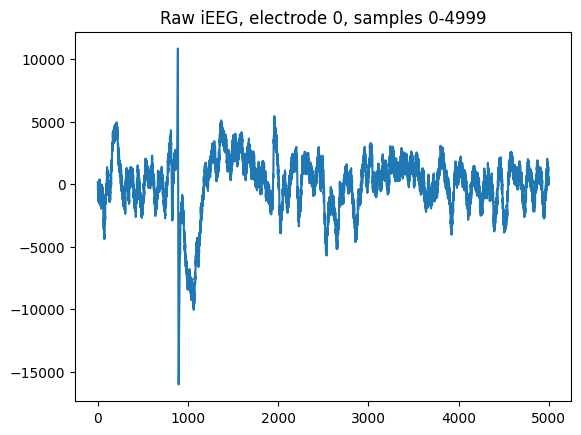

In [34]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Photodiode
- examine photodiode 

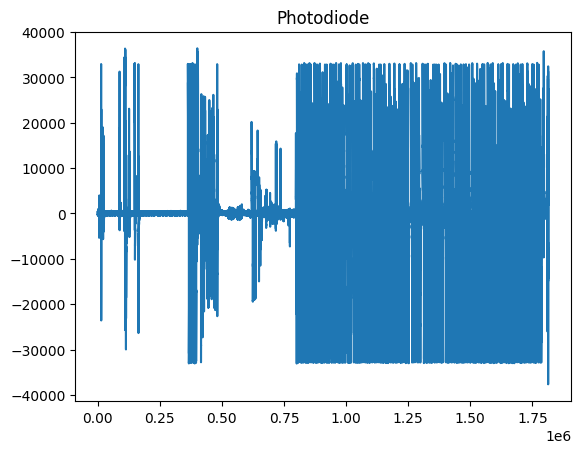

In [35]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("Photodiode")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [36]:
mne_data.save(f'{neural_dir}{subj_id}/nlx_photodiode.fif', picks='Photodiode', overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/nlx_photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/nlx_photodiode.fif
[done]


In [37]:
mne_data.drop_channels(['Photodiode'])

<RawArray | 168 x 1815856 (3631.7 s), ~2.27 GB, data loaded>

### Notch filter line noise

In [14]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:   38.0s finished


<RawEDF | MS026_SWB.edf, 275 x 3340032 (3261.7 s), ~6.84 GB, data loaded>

### Anatomical Localization

In [15]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS026_SWB.edf, 275 x 3340032 (3261.7 s), ~6.84 GB, data loaded>

In [16]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x  \
0     LaCaS1    A32sg_L  -2.954574  41.329210   4.799997  -3.150189   
1    LaCaS10   A9/46d_L -14.150090  45.726392  48.399994 -14.612690   
2    LaCaS11      A9l_L -15.349610  46.126136  53.199994 -16.068791   
3    LaCaS12      A9l_L -16.149290  46.126136  57.999994 -17.096981   
4    LaCaS13    Unknown -16.948969  46.126136  63.599993 -18.060868   
..       ...        ...        ...        ...        ...        ...   
163   RmOlF6     A11l_R  33.430855  50.123574   8.399997  36.273305   
164   RmOlF7  A12/47o_R  37.429254  49.723831  10.399996  40.477926   
165   RmOlF8  A12/47l_R  42.227333  49.723831  12.399996  45.600992   
166   RmOlF9     A45r_R  46.625571  49.723831  14.799996  50.223671   
167   uRmOlF      A13_R   7.441263  48.524599  -4.000003   8.405835   

         mni_y      mni_z       gm  \
0    27.626674 -11.313929     Gray   
1    45.647438  30.886915    White   
2    47.523347  35.735259     Gray   
3    48.985539  40.715012     Gray   
4    50.562598  46.419275  Unknown   
..         ...        ...      ...   
163  37.087206 -11.909190     Gray   
164  37.432671  -9.831393     Gray   
165  38.133258  -7.732312     Gray   
166  38.960073  -5.163690     Gray   
167  31.034159 -22.937916     Gray   

                                                   NMM      Anat  \
0                   Left ACgG anterior cingulate gyrus  Area s24   
1                           Left Cerebral White Matter   Unknown   
2                      Left SFG superior frontal gyrus   Unknown   
3                      Left SFG superior frontal gyrus   Unknown   
4                                              Unknown   Unknown   
..                                                 ...       ...   
163                   Right LOrG lateral orbital gyrus   Unknown   
164                        Right Cerebral White Matter   Unknown   
165  Right OrIFG orbital part of the inferior front...   Unknown   
166  Right TrIFG triangular part of the inferior fr...   Unknown   
167                             Right GRe gyrus rectus  Area Fo1   

                    AnatMacro    BN246                               YBA_1  \
0         L Mid Orbital Gyrus     L CG              Left cingulate gyrus C   
1    L Superior Frontal Gyrus    L MFG                             Unknown   
2    L Superior Frontal Gyrus    L SFG     Left superior frontal gyrus 2 D   
3    L Superior Frontal Gyrus    L SFG     Left superior frontal gyrus 2 D   
4    L Superior Frontal Gyrus  Unknown     Left superior frontal gyrus 2 D   
..                        ...      ...                                 ...   
163       R IFG (p Orbitalis)    R OrG              Right pars orbitalis B   
164       R IFG (p Orbitalis)    R OrG              Right pars orbitalis B   
165       R IFG (p Orbitalis)    R OrG  Right anterior pars triangularis A   
166       R IFG (p Orbitalis)    R IFG  Right anterior pars triangularis A   
167            R Rectal Gyrus    R OrG           Right frontal orbital 4 A   

    ManualExamination  Notes  
0                 NaN    NaN  
1                  WM    NaN  
2                  WM    NaN  
3                 OOB    NaN  
4                 OOB    NaN  
..                ...    ...  
163                WM    NaN  
164               NaN    NaN  
165               NaN    NaN  
166               NaN    NaN  
167               NaN    NaN  

[168 rows x 16 columns]

In [17]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS13',
 'LaCaS14',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMsP1',
 'LCMsP10',
 'LCMsP11',
 'LCMsP12',
 'LCMsP13',
 'LCMsP14',
 'LCMsP2',
 'LCMsP3',
 'LCMsP4',
 'LCMsP5',
 'LCMsP6',
 'LCMsP7',
 'LCMsP8',
 'LCMsP9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'uLHplT',
 'LHtOc1',
 'LHtOc10',
 'LHtOc11',
 'LHtOc12',
 'LHtOc13',
 'LHtOc14',
 'LHtOc15',
 'LHtOc16',
 'LHtOc2',
 'LHtOc3',
 'LHtOc4',
 'LHtOc5',
 'LHtOc6',
 'LHtOc7',
 'LHtOc8',
 'LHtOc9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'uLmOlF',
 'RaCaS1',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS13'

In [18]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c33', 'c34', 'rcmsp15', 'rcmsp16', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'abs1', 'abs2', 'chest1', 'chest2', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [19]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [20]:
unmatched_seeg #make sure there are no unmatched names


[]

In [21]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [22]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'rmolf1': 'rmolf1',
 'rmolf2': 'rmolf2',
 'rmolf3': 'rmolf3',
 'rmolf4': 'rmolf4',
 'rmolf5': 'rmolf5',
 'rmolf6': 'rmolf6',
 'rmolf7': 'rmolf7',
 'rmolf8': 'rmolf8',
 'rmolf9': 'rmolf9',
 'lcmsp1': 'lcmsp1',
 'lcmsp2': 'lcmsp2',
 'lcmsp3': 'lcmsp3',
 'lcmsp4': 'lcmsp4',
 'lcmsp5': 'lcmsp5',
 'lcmsp6': 'lcmsp6',
 'lcmsp7': 'lcmsp7',
 'lcmsp8': 'lcmsp8',
 'lcmsp9': 'lcmsp9',
 'lcmsp10': 'lcmsp10',
 'lcmsp11': 'lcmsp11',
 'lcmsp12': 'lcmsp12',
 'lcmsp13': 'lcmsp13',
 'lcmsp14': 'lcmsp14',
 'c33': 'c33',
 'c34': 'c34',
 'rcmsp1': 'rcmsp1',
 'rcmsp2': 'rcmsp2',
 'rcmsp3': 'rcmsp3',
 'rcmsp4': 'rcmsp4',
 'rcmsp5': 'rcmsp5',
 'rcmsp6': 'rcmsp6',
 'rcmsp7': 'rcmsp7',
 'rcmsp8': 'rcmsp8',
 'rcmsp9': 'rcmsp9',
 'rcmsp10': 'rcmsp10',
 'rcmsp11': 'rcmsp11',
 'rcmsp12': 'rcmsp12',
 'rcmsp13': 'rcmsp13',
 'rcmsp

In [23]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS026_SWB.edf, 275 x 3340032 (3261.7 s), ~6.84 GB, data loaded>

In [24]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 82 left sEEG and 84 right sEEG electrodes
We have a total of 166 sEEG electrodes


In [25]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS026_SWB.edf, 275 x 3340032 (3261.7 s), ~6.84 GB, data loaded>

In [26]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS026_SWB.edf, 166 x 3340032 (3261.7 s), ~4.13 GB, data loaded>

In [27]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS026_SWB.edf, 166 x 3340032 (3261.7 s), ~4.13 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [28]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [29]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [30]:
probe_ch_counts

{'lacas': 14,
 'laglt': 9,
 'lcmsp': 14,
 'lhplt': 10,
 'lhtoc': 16,
 'lmcms': 10,
 'lmolf': 9,
 'racas': 14,
 'raglt': 9,
 'rcmsp': 14,
 'rhplt': 10,
 'rhtoc': 16,
 'rmcms': 10,
 'rmolf': 9,
 'ulhplt': 1,
 'ulmolf': 1,
 'uraglt': 1,
 'urmolf': 1}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [270]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) # good for this patient

['lhplt3', 'lmolf2', 'raglt2', 'rcmsp10', 'rhplt10', 'rmolf2']

<IPython.core.display.Javascript object>


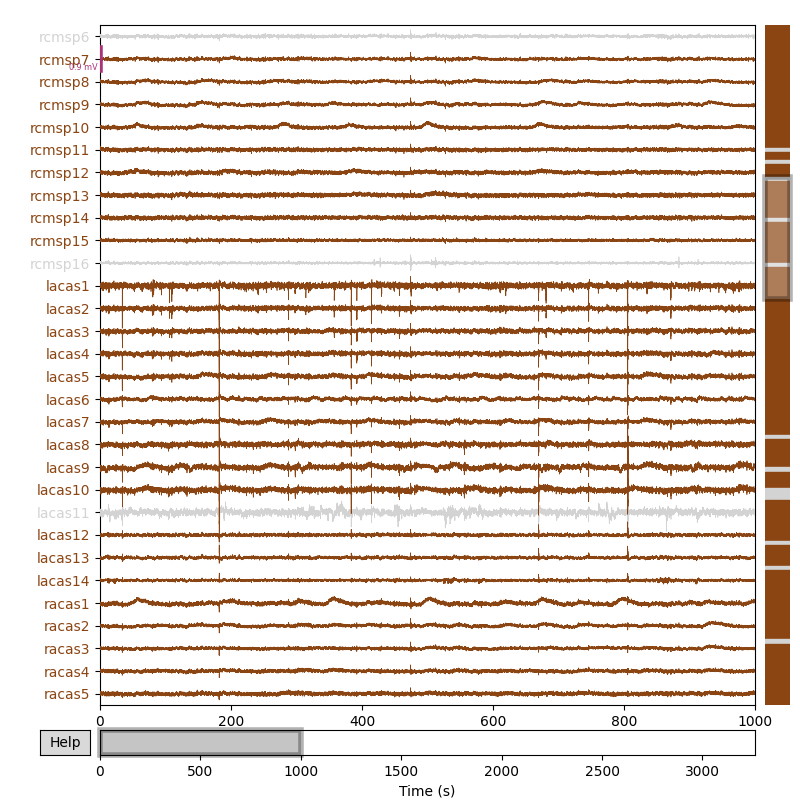

In [349]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=30, scalings=mne_data._data.max()/20)


In [350]:
mne_data.info['bads']

['lacas11',
 'laglt5',
 'rhplt9',
 'raglt9',
 'lhplt1',
 'lhplt2',
 'rcmsp16',
 'rhplt3',
 'raglt4',
 'rhtoc1',
 'rcmsp2',
 'lcmsp13',
 'rcmsp6']

In [352]:
mne_data.info #sanity check that bads info saved

<Info | 12 non-empty values
 bads: 13 items (lacas11, laglt5, rhplt9, raglt9, lhplt1, lhplt2, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 166 sEEG
 custom_ref_applied: False
 dig: 164 items (164 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 512.0 Hz
 meas_date: 2001-01-01 11:15:14 UTC
 meas_id: 4 items (dict)
 nchan: 166
 projs: []
 sfreq: 1024.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [353]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [354]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=22, n_times=3340032
    Range : 0 ... 3340031 =      0.000 ...  3261.749 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lcmsp2-lcmsp3, lcmsp3-lcmsp4, lcmsp4-lcmsp5, lcmsp5-lcmsp6, lcmsp6-lcmsp7, lcmsp12-lcmsp14, lhtoc14-lhtoc15, lmolf1-lmolf2, lmolf8-lmolf9, racas6-racas7, raglt1-raglt2, raglt2-raglt3, raglt7-raglt8, rcmsp1-rcmsp3, rcmsp12-rcmsp13, rhplt1-rhplt2, rhplt2-rhplt4, rhplt7-rhplt8, rhplt8-rhplt10, rmolf7-rmolf8, rmolf8-rmolf9


In [355]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 22 x 3340032 (3261.7 s), ~560.7 MB, data loaded>

In [356]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lcmsp2-lcmsp3',
 'lcmsp3-lcmsp4',
 'lcmsp4-lcmsp5',
 'lcmsp5-lcmsp6',
 'lcmsp6-lcmsp7',
 'lcmsp12-lcmsp14',
 'lhtoc14-lhtoc15',
 'lmolf1-lmolf2',
 'lmolf8-lmolf9',
 'racas6-racas7',
 'raglt1-raglt2',
 'raglt2-raglt3',
 'raglt7-raglt8',
 'rcmsp1-rcmsp3',
 'rcmsp12-rcmsp13',
 'rhplt1-rhplt2',
 'rhplt2-rhplt4',
 'rhplt7-rhplt8',
 'rhplt8-rhplt10',
 'rmolf7-rmolf8',
 'rmolf8-rmolf9']

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


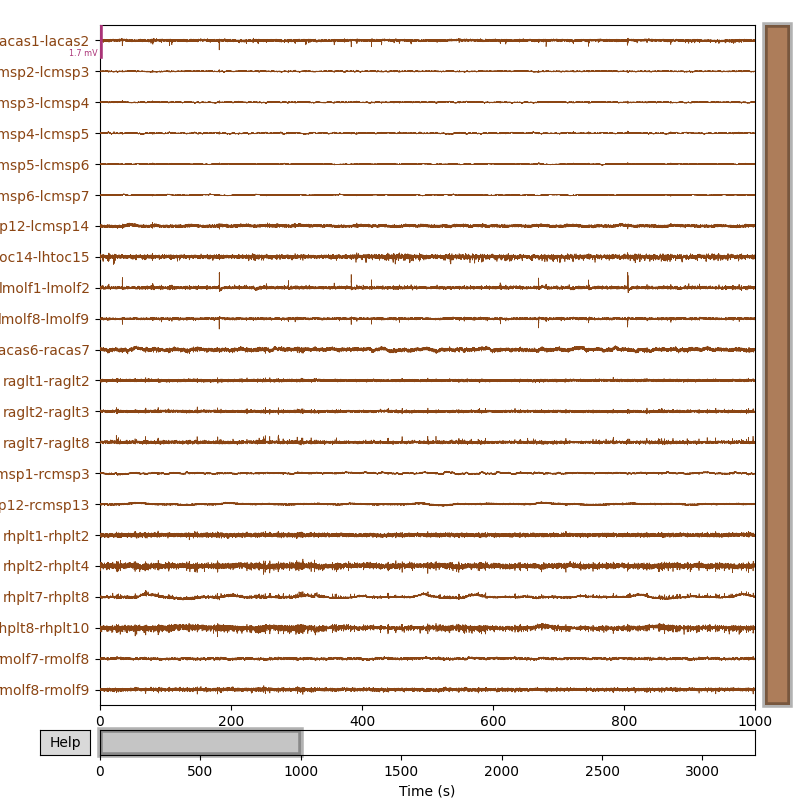

In [357]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.250 (s)


<IPython.core.display.Javascript object>


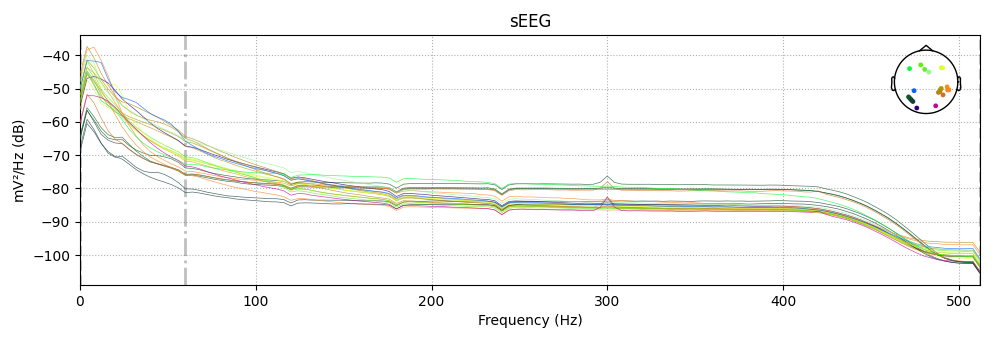

<IPython.core.display.Javascript object>


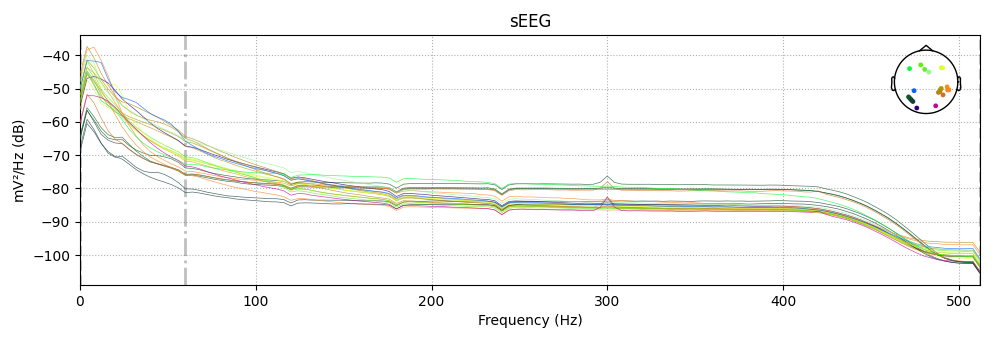

In [358]:
mne_data_bp_reref.compute_psd().plot()

In [359]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/bp_ref_ieeg.fif
[done]


## Save mne_data

In [360]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_ieeg.fif
Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_ieeg-1.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_ieeg-1.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [361]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [33]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/nlx_photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/photodiode.fif...
Isotrak not found
    Range : 0 ... 3340031 =      0.000 ...  3261.749 secs
Ready.
Reading 0 ... 3340031  =      0.000 ...  3261.749 secs...


In [34]:
photodiode_data

<Raw | photodiode.fif, 1 x 3340032 (3261.7 s), ~25.5 MB, data loaded>

In [81]:
temp_diode = photodiode_data.copy()
# temp_data = -temp_diode._data[0,:]
temp_data = temp_diode._data[0,:]
# temp_data = np.abs(temp_diode._data[0, :])
temp_data[0:1250000] = 0.06
temp_diode._data = temp_data

In [37]:
temp_diode2 = photodiode_data.copy()

# Specify the window size for the rolling mean
window_size = 3

# Calculate the rolling mean
rolling_mean = pd.Series(temp_diode2._data[0,:]).rolling(window=window_size).mean()

# Subtract the rolling mean from the original signal
detrended_data = temp_diode2._data[0,:] - rolling_mean

detrended_data.fillna(0, inplace=True)

detrended_data = detrended_data.values

# temp_data[temp_data>0.8] = -2
# detrended_data[0:450000] = 0

# detrended_data[570000:] = 0

temp_diode2._data = detrended_data

In [93]:
neural_ts = sync_utils.get_neural_ts_photodiode(temp_diode, smoothSize=11, height=1)

In [94]:
neural_ts.shape

(145,)

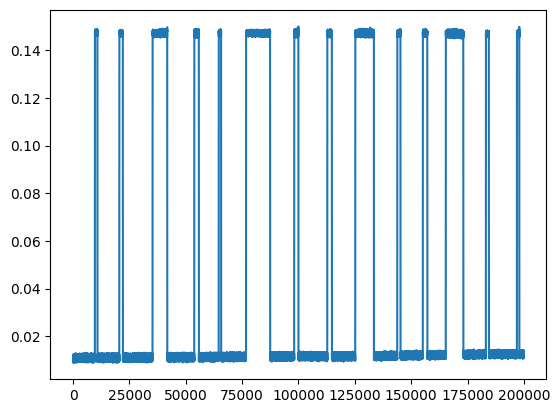

In [43]:
plt.plot(photodiode_data._data[0, 1500000:1700000])


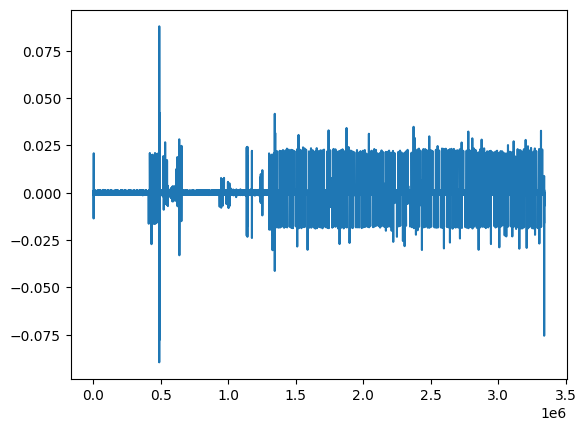

In [38]:
plt.plot(detrended_data)
# plt.plot(neural_ts * photodiode_data.info['sfreq'], 0.01 * np.ones_like(neural_ts * photodiode_data.info['sfreq']),'.')
plt.show()

In [ ]:
plt.plot(neural_ts, 'o')

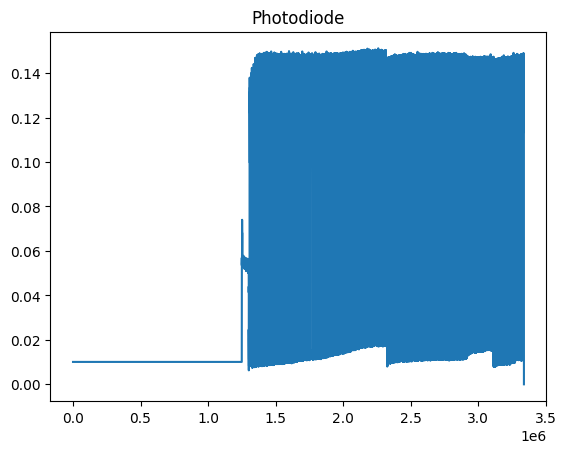

In [45]:
# plt.plot(temp_diode._data[1000000:1100000])
# plt.plot(temp_diode._data[1000000:1300000])
plt.plot(temp_diode._data[:])
# plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
# plt.plot(photodiode_data._data[0,:])

# plt.plot(scipy.stats.zscore(temp_diode._data[:]))
plt.title("Photodiode")
plt.show()

In [100]:
### Photodiode alignment
smoothSize=11
windSize=12

height=1

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

12 blocks
............

found matches for 72 of 145 pulses
8 blocks
........

found matches for 17 of 145 pulses


In [101]:
slope, offset

(0.9598792004646878, 2318.667550985241)

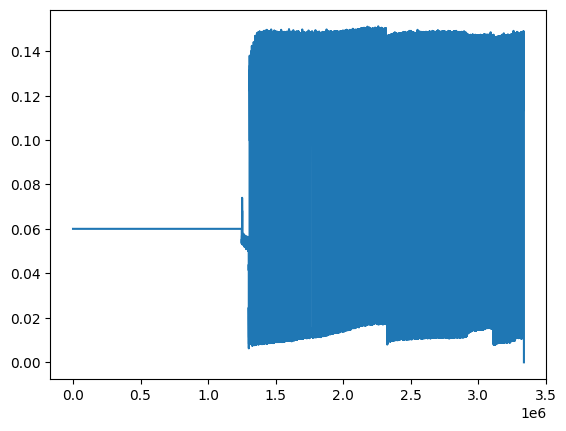

In [82]:
plt.plot(temp_diode._data)

In [67]:
offset

2635.599690185096

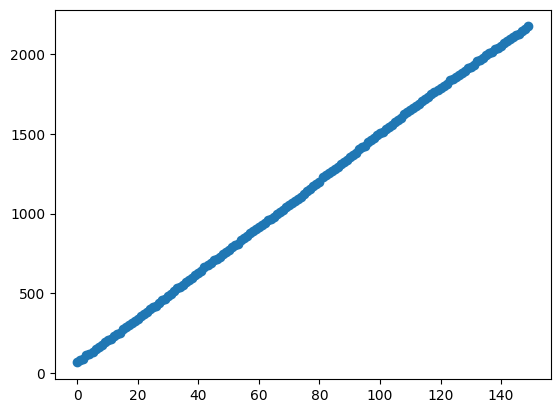

In [78]:
plt.plot(beh_ts, 'o')

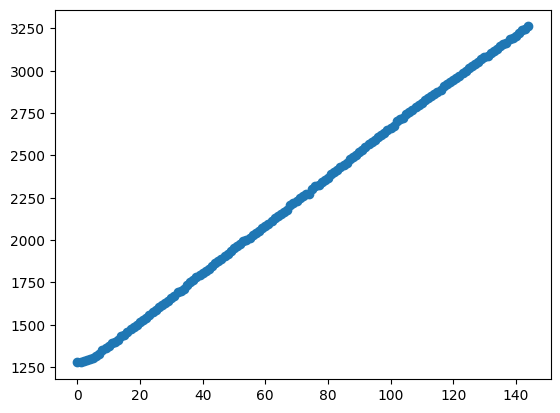

In [95]:
plt.plot(neural_ts, 'o')

In [50]:
print(slope, offset,smoothSize,windSize,height)

1.0408098931769547 1275.3255705607326 11 10 1.5


In [75]:
print(slope, offset,smoothSize,windSize,height)

0.9432336378488738 1377.6620272150546 11 15 0.1


In [76]:
[(x*slope + offset) for x in beh_ts]

[1438.9614103487438,
 1452.0117357229312,
 1461.8645854651081,
 1480.546658093718,
 1490.384923651783,
 1500.9177729723558,
 1519.9688818002594,
 1530.1189876617193,
 1540.8625914085835,
 1559.3436627411866,
 1569.4106667951664,
 1580.283058342494,
 1596.4232893060885,
 1605.9799879271477,
 1616.4941751815368,
 1635.3910714406948,
 1646.9875775093512,
 1658.295948150541,
 1675.4730095430536,
 1686.3162064999533,
 1695.6559379920623,
 1713.6846586186239,
 1725.1315029379302,
 1735.5169929424255,
 1754.5684296383126,
 1764.823264617092,
 1775.2037177539307,
 1793.3462618736487,
 1806.26148525288,
 1815.349176888055,
 1835.3748375402565,
 1846.9338685592224,
 1860.6064272429053,
 1877.782212157279,
 1888.6363310051588,
 1899.609796167789,
 1914.3138336554675,
 1924.7573886511454,
 1937.189789218533,
 1957.9621150333141,
 1970.0479347761047,
 1980.2963707635906,
 2004.1718264920314,
 2013.5319715408066,
 2027.4060795393502,
 2044.1922787778599,
 2053.698771713268,
 2064.4508066482895,
 208

In [269]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [70]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [71]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [72]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [73]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/bp_ref_ieeg.fif...
    Range : 0 ... 3340031 =      0.000 ...  3261.749 secs
Ready.
Reading 0 ... 3340031  =      0.000 ...  3261.749 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 541 samples (0.528 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    3.7s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 41 events and 3073 original time points ...
0 bad epochs dropped


ValueError: metadata must have the same number of rows (150) as events (41)

In [372]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~77.5 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~180.6 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [373]:
behav_df.columns

Index(['Round', 'Trial Num', 'TrialType', 'TrialOnset', 'ChoiceOnset',
       'DecisionOnset', 'FeedbackOnset', 'RT', 'SafeBet', 'LowBet', 'HighBet',
       'HighBetPos', 'GamblePos', 'ChoicePos', 'GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegr

In [374]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegret_emmap', 'util_dRegret_emmap',
       'util_tRelief_emmap', 'util_dRelief_emmap', 'util_RPE_emmap',
       'util_pRPE_emmap', 'util_nRPE_emmap']

In [375]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 80 columns
Replacing existing metadata with 80 columns


In [376]:
epochs_all_evs[event].metadata

lacas1-lacas2 lcmsp2-lcmsp3 lcmsp3-lcmsp4      lcmsp4-lcmsp5  \
0             NaN           NaN           NaN                NaN   
1             NaN           NaN           NaN  [1147.4892578125]   
2             NaN           NaN           NaN                NaN   
3             NaN           NaN           NaN                NaN   
4             NaN           NaN           NaN                NaN   
..            ...           ...           ...                ...   
145           NaN           NaN           NaN                NaN   
146           NaN           NaN           NaN                NaN   
147           NaN           NaN           NaN                NaN   
148           NaN           NaN           NaN                NaN   
149           NaN           NaN           NaN                NaN   

    lcmsp5-lcmsp6 lcmsp6-lcmsp7 lcmsp12-lcmsp14 lhtoc14-lhtoc15 lmolf1-lmolf2  \
0             NaN           NaN             NaN             NaN           NaN   
1           noise           NaN             NaN             NaN           NaN   
2           noise           NaN             NaN             NaN           NaN   
3             NaN           NaN             NaN             NaN           NaN   
4             NaN           NaN             NaN             NaN           NaN   
..            ...           ...             ...             ...           ...   
145           NaN           NaN             NaN             NaN           NaN   
146           NaN           NaN             NaN             NaN           NaN   
147           NaN           NaN             NaN             NaN           NaN   
148           NaN           NaN             NaN             NaN           NaN   
149           NaN           NaN             NaN             NaN           NaN   

    lmolf8-lmolf9  ... util_dCPE_emmap util_tCF_emmap util_dCF_emmap  \
0             NaN  ...        1.349582      -1.349582      -1.349582   
1             NaN  ...       -0.344166       0.344166       0.344166   
2             NaN  ...       -0.123754       0.235534       0.123754   
3             NaN  ...       -0.515210       0.839092       0.515210   
4             NaN  ...        0.274963       0.000000       0.123754   
..            ...  ...             ...            ...            ...   
145           NaN  ...        0.334033      -0.881010      -0.334033   
146           NaN  ...       -0.132721       0.132721       0.132721   
147           NaN  ...       -0.209494       0.398718       0.209494   
148           NaN  ...       -0.013886      -0.807604      -0.807604   
149           NaN  ...       -0.209494       0.338220       0.209494   

    util_tRegret_emmap util_dRegret_emmap util_tRelief_emmap  \
0             0.000000           0.000000           1.349582   
1            -0.344166          -0.344166           0.000000   
2            -0.235534          -0.123754           0.000000   
3            -0.839092          -0.515210           0.000000   
4             0.000000           0.000000           0.398718   
..                 ...                ...                ...   
145           0.000000           0.000000           0.881010   
146          -0.132721          -0.132721           0.000000   
147          -0.398718          -0.209494           0.000000   
148           0.000000           0.000000          -0.013886   
149          -0.338220          -0.209494           0.000000   

    util_dRelief_emmap util_RPE_emmap util_pRPE_emmap util_nRPE_emmap  
0             1.349582       0.000000         0.00000        0.000000  
1             0.000000       0.000000         0.00000        0.000000  
2             0.000000      -0.235534         0.00000       -0.235534  
3             0.000000      -0.839092         0.00000       -0.839092  
4             0.274963       0.000000         0.00000        0.000000  
..                 ...            ...             ...             ...  
145           0.334033       0.881010         0.88101        0.000000  
146 

### Save raw epoched data 

In [377]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [378]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [379]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)

In [380]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [381]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


Not setting metadata


In [382]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 22, ~774.3 MB>}

In [383]:
power_epochs = {}

In [384]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=False, ## make sure this is FALSE!
                                                  baseline_only=True)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



Not setting metadata
Not setting metadata
Adding metadata with 80 columns


In [385]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 22, ~3.78 GB>

In [386]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [387]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

01292024


In [388]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)
# del epochs_all_baseline, power_epochs, plot_data

1064.9528831244538


<IPython.core.display.Javascript object>


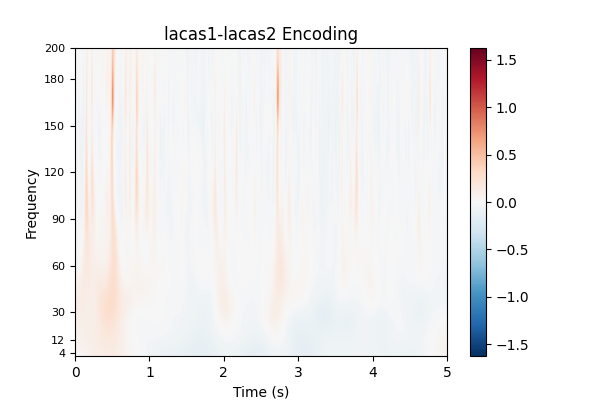

<IPython.core.display.Javascript object>


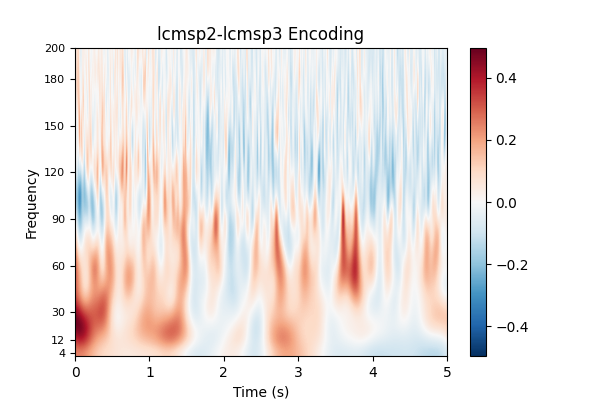

<IPython.core.display.Javascript object>


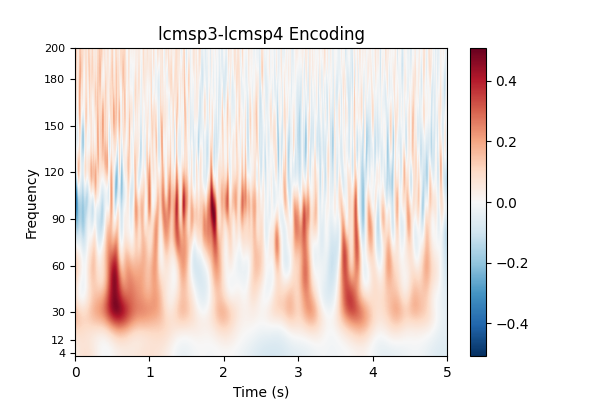

<IPython.core.display.Javascript object>


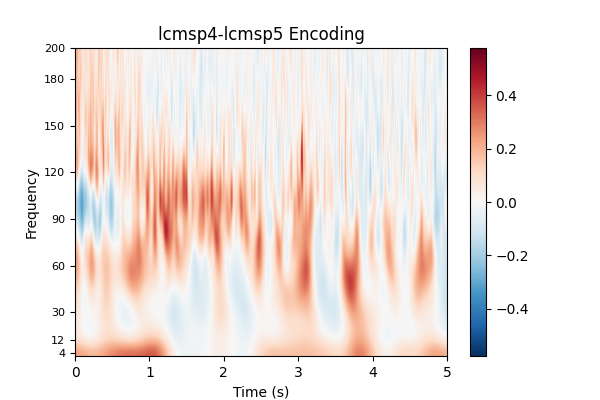

<IPython.core.display.Javascript object>


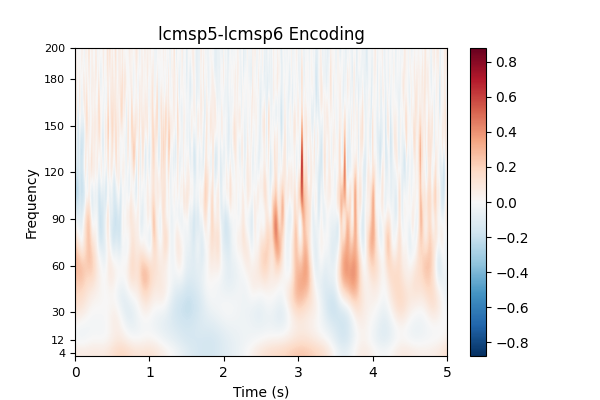

<IPython.core.display.Javascript object>


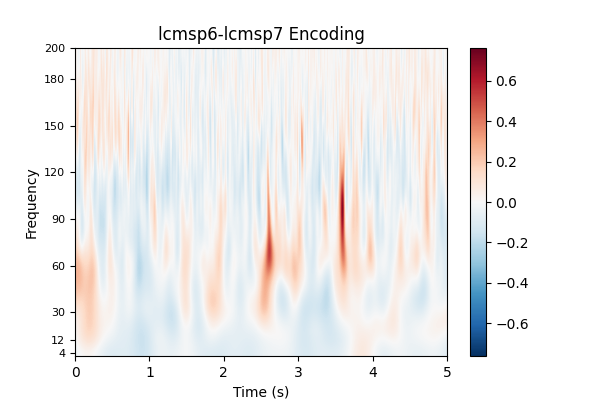

<IPython.core.display.Javascript object>


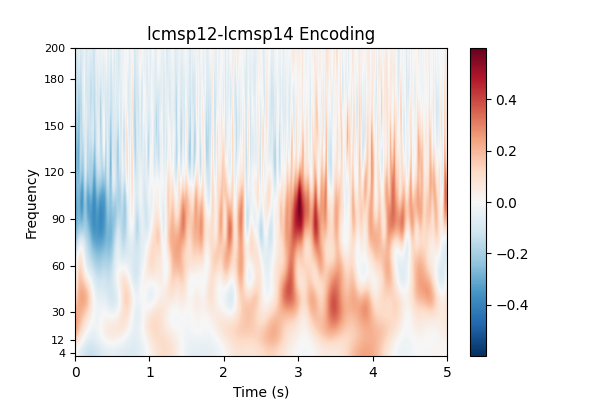

<IPython.core.display.Javascript object>


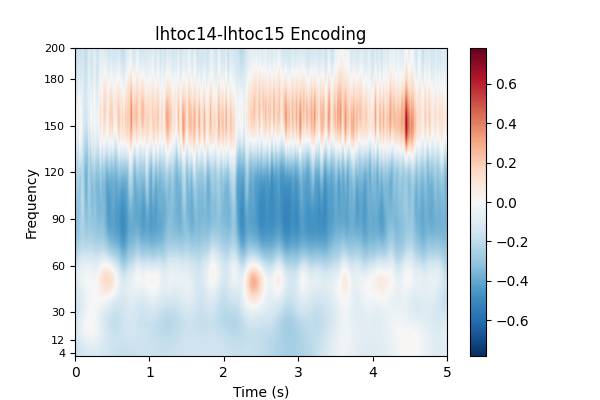

<IPython.core.display.Javascript object>


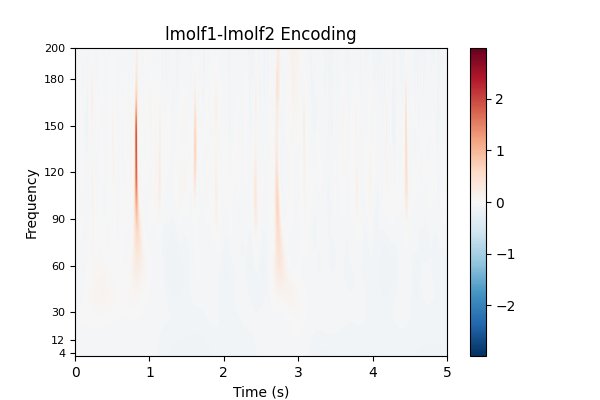

<IPython.core.display.Javascript object>


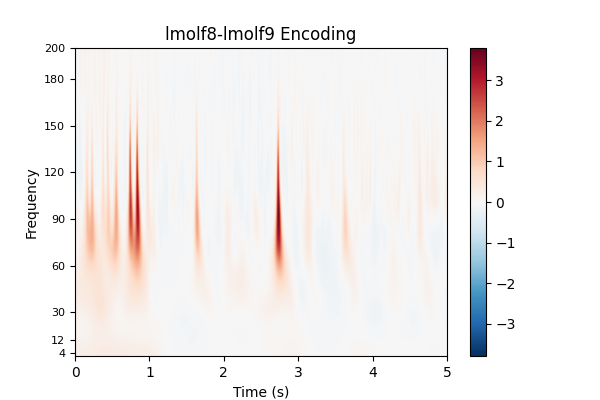

<IPython.core.display.Javascript object>


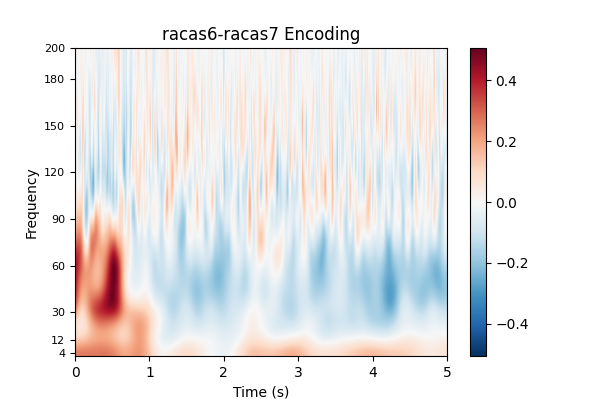

<IPython.core.display.Javascript object>


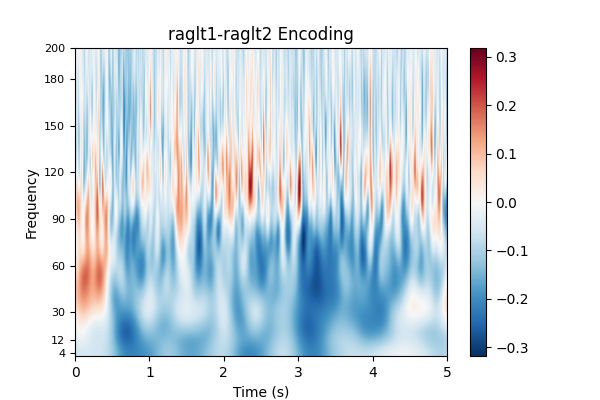

<IPython.core.display.Javascript object>


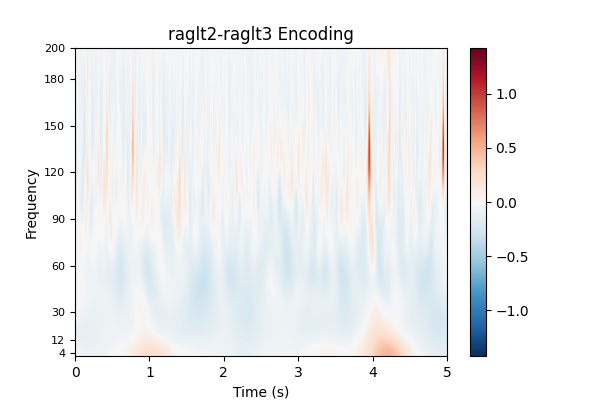

<IPython.core.display.Javascript object>


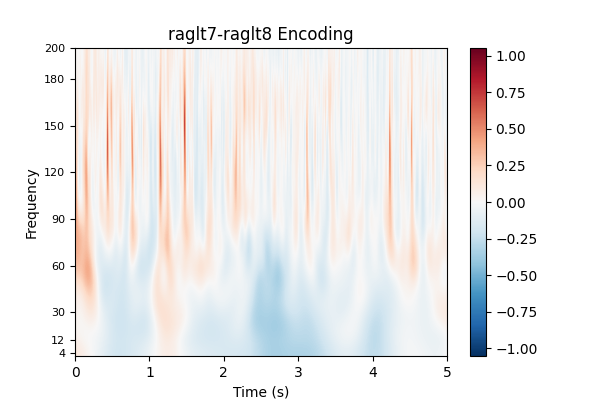

<IPython.core.display.Javascript object>


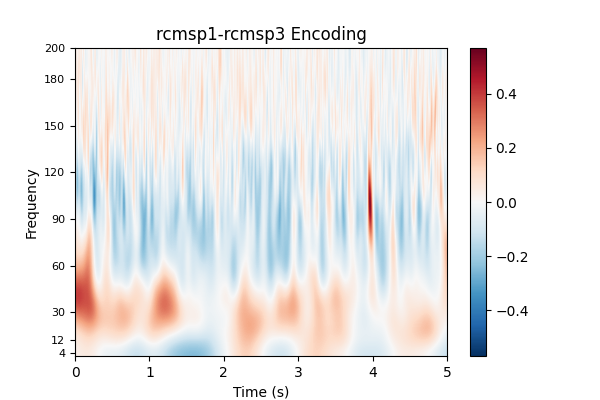

<IPython.core.display.Javascript object>


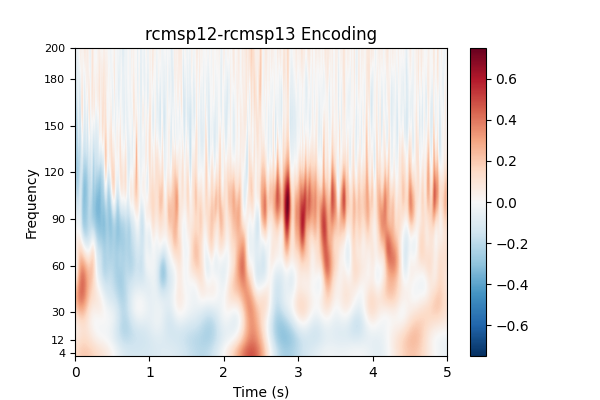

<IPython.core.display.Javascript object>


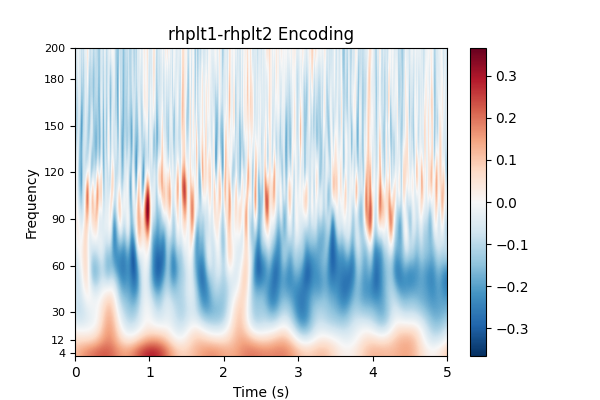

<IPython.core.display.Javascript object>


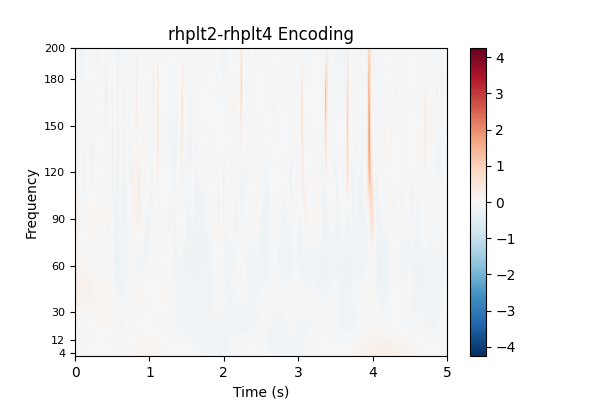

<IPython.core.display.Javascript object>


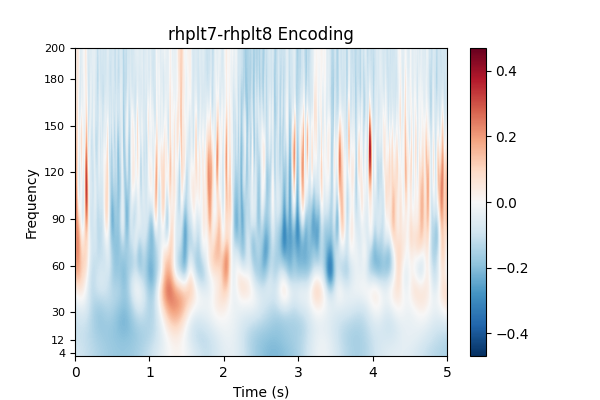

<IPython.core.display.Javascript object>


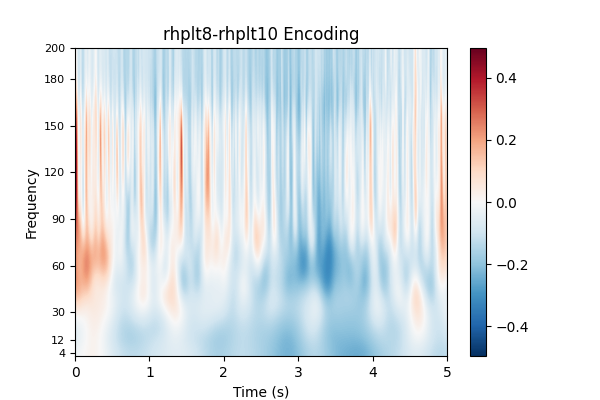

<IPython.core.display.Javascript object>


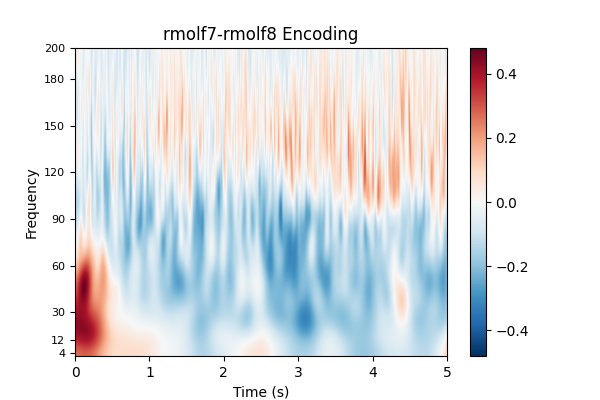

<IPython.core.display.Javascript object>


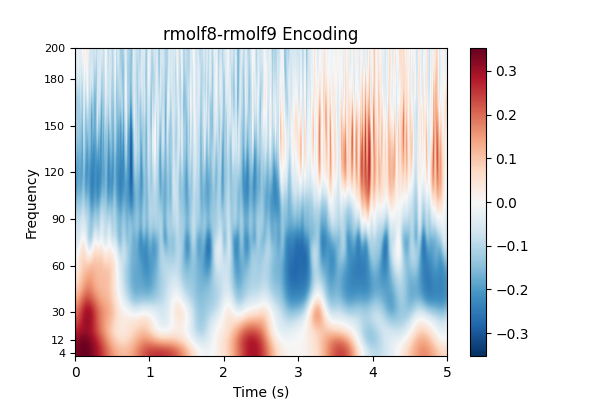

In [389]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
#     plt.close()
